
# Time Series Forecasting using Auto Arima API

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date

# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy
# Set font scale and style
plt.rcParams.update({'font.size': 18})

# Stat models
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import custom class
%run -i '../src/helper/ts_analysis.py'

In [3]:
# Instantiate the class
fxn = TimeSeriesAnalysis()

# Load  data

In [22]:
ts = pd.read_csv('../data/ts_yearly.csv') # load data
ts.year = pd.to_datetime(ts['year'], format = '%Y')  # convert to datetime
ts.index = ts.year # make date the dataframe index
ts = ts.drop(['year'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (122, 1)


,tot_occurrence
year,
1959-01-01,33
1990-01-01,303
1903-01-01,12
1975-01-01,67
1977-01-01,141


#  Create a Test  Set

In [24]:
y = ts['tot_occurrence']
N = len(y)

train_start, train_end = '1900-01-01','2009-01-01'
test_start, test_end = '2010-01-01', '2020-01-01'

y_train = y[train_start: train_end]
y_test = y[test_start: test_end]

# Normalization

In [25]:
# Standardization
scaler_y = StandardScaler() 
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)) 

# ARIMA Model

In [26]:
# Train arima model from auto arima API
arima_ = pm.auto_arima(y_train_scaled, max_p = 4, max_q = 4, 
                 test = 'adf', stepwise=True, suppress_warnings=True, 
                 error_action='ignore',random_state= 42, trace = True, n_fits= 20)
arima_.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=316.166, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=318.141, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=318.145, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=314.166, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=319.456, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.484 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  110
Model:                        SARIMAX   Log Likelihood                -156.083
Date:                Mon, 31 May 2021   AIC                            314.166
Time:                        07:46:37   BIC                            316.867
Sample:                             0   HQIC                           315.262
                                - 110                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0000      0.107      9.318      0.000       0.790       1.210
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                48.71
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             1.52
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

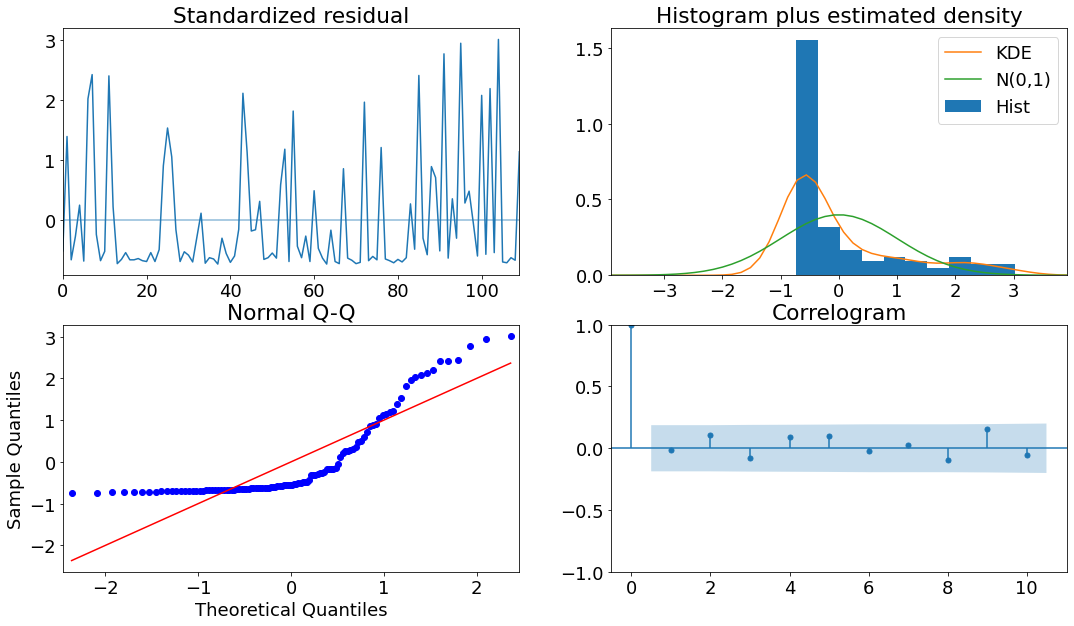

In [27]:
arima_.plot_diagnostics(figsize=(18,10))
plt.show()

# Test prediction

In [28]:
y_pred, conf_int = arima_.predict(n_periods = len(y_test),return_conf_int=True)

# Inverse transform scale
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1)).flatten()

# Performance measures

In [29]:
fxn.error_metrics(y_test, y_pred)

{'MAE = 272.064', 'MAPE = 71.761', 'RMSE = 274.348', 'R^2 = -59.306'}

In [30]:
y_pred[y_pred<0] = 0

y_low = conf_int[:,0]
y_low = scaler_y.inverse_transform(y_low.reshape(-1,1)).flatten()
y_high = conf_int[:,1]
y_high = scaler_y.inverse_transform(y_high.reshape(-1,1)).flatten()

results = pd.DataFrame()
results['y_pred'] = y_pred
results['y_low'] = y_low
results['y_high'] = y_high
results.index = y_test.index

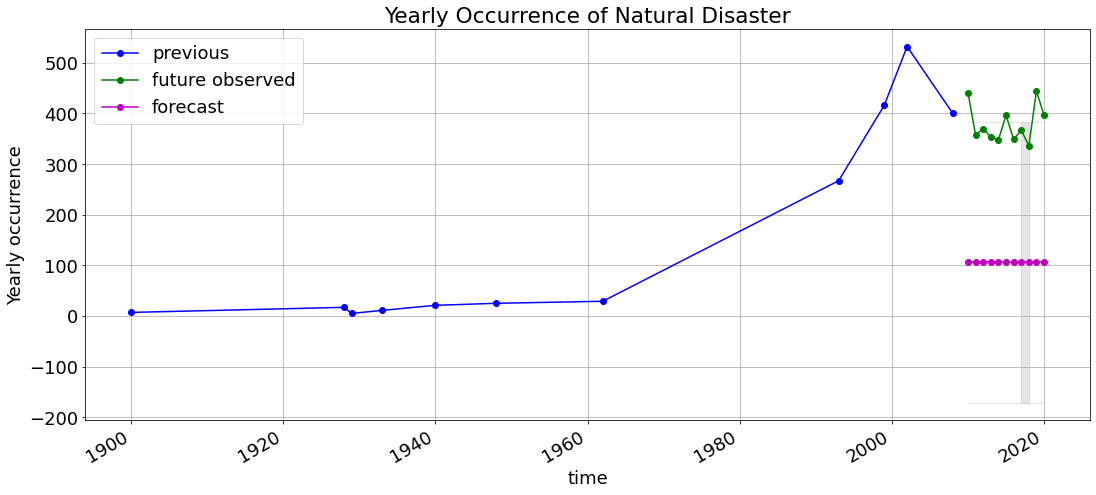

In [32]:
plt.figure(figsize = (18,8))

y_train.iloc[-len(y_test):].plot(label = 'previous',  marker = 'o', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['y_pred'].plot(label = 'forecast', marker = 'o', color = 'm')

plt.fill_between(results.index, results['y_low'], results['y_high'], color='k', alpha=0.1)
plt.xlabel('time')
plt.grid(True)
plt.ylabel('Yearly occurrence')
plt.title('Yearly Occurrence of Natural Disaster')
plt.legend()
plt.savefig('../images/fig.png')
plt.show()

# Test set error

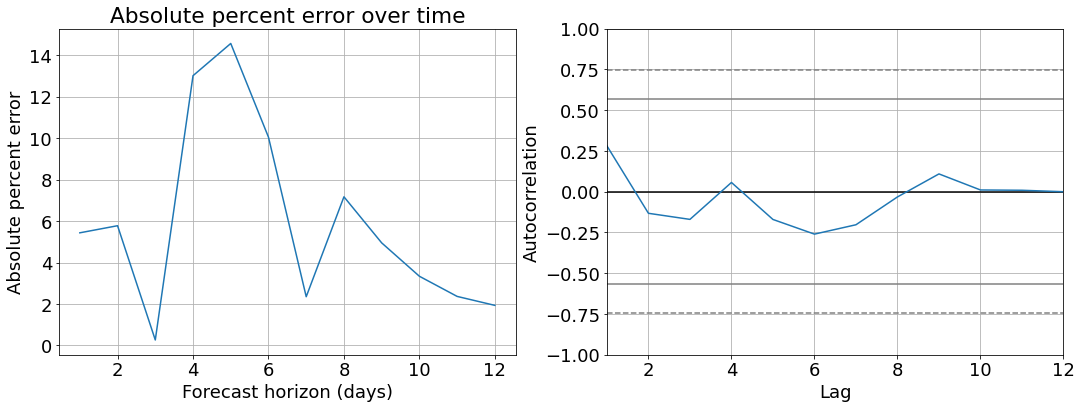

In [14]:
plt.figure(figsize = (18,6))
abs_err = 100*np.abs((y_pred - y_test.values)/(y_test.values))

plt.subplot(121)
plt.plot(np.arange(1, len(abs_err)+1), abs_err)
plt.grid(True)
plt.xlabel('Forecast horizon (days)')
plt.ylabel('Absolute percent error')
plt.title('Absolute percent error over time')

plt.subplot(122)
pm.autocorr_plot(abs_err)
plt.show()

In [15]:
# plt.figure(figsize = (8,6))
# abs_err = 100*np.abs((y_pred - y_test.values)/(y_test.values))

# plt.plot(acorr_ljungbox(abs_err, lags = 11)[0], 'o')
# plt.axhline(y=0.05,linestyle= '--', color = 'k')
# plt.ylabel('p-value', fontsize = 20)
# plt.xlabel('Lag', fontsize = 20)
# plt.title('p-values for Ljung-Box statistic', fontsize = 20)